In [1]:
import os
import sys
from dotenv import load_dotenv

notebook_path = os.getcwd()

# One level up from the notebook
PROJECT_ROOT = os.path.abspath(os.path.join(notebook_path, "../"))

DATA_ROOT = os.path.join(PROJECT_ROOT, "data")

sys.path.insert(1, PROJECT_ROOT)
load_dotenv()

True

In [2]:
import glob

import databento as db
import pandas as pd
import numpy as np
import datetime

import plotly.graph_objects as go

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import re

Load saved Options price OHLCV and aggregate

In [ ]:
symbol = "AAPL"
df = pd.read_csv(os.path.join(DATA_ROOT, "databento", f"{symbol}-options-ohlcv-1d.csv"), index_col=0)

df.index = pd.to_datetime(df.index, utc=True)
df['expiry_date'] = pd.to_datetime(df['expiry_date'], utc=True)

In [ ]:
df.head()

,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol_base,expiry_date,type,strike
ts_event,,,,,,,,,,,,
2023-03-28 00:00:00+00:00,35,22,16778420,1.20,1.20,0.96,0.96,61,AAPL,2023-04-21 00:00:00+00:00,P,146.0
2023-03-28 00:00:00+00:00,35,26,16778420,1.09,1.09,1.09,1.09,38,AAPL,2023-04-21 00:00:00+00:00,P,146.0
2023-03-28 00:00:00+00:00,35,31,16778420,1.20,1.20,1.10,1.15,529,AAPL,2023-04-21 00:00:00+00:00,P,146.0
2023-03-28 00:00:00+00:00,35,36,16778420,1.10,1.20,1.10,1.20,51,AAPL,2023-04-21 00:00:00+00:00,P,146.0
2023-03-28 00:00:00+00:00,35,25,2117,19.00,19.00,19.00,19.00,1,AAPL,2025-12-19 00:00:00+00:00,C,200.0


Load saved Stock price OHLCV and aggregate

In [36]:
def read_df_with_prefix(directory, prefix):
    tmp = []

    for filename in glob.glob(os.path.join(directory, f"{prefix}*")):
        tmp.append(pd.read_csv(filename, index_col=0))

    return pd.concat(tmp, axis=0)

timeframe = "1d"

directory = os.path.join(DATA_ROOT, "databento")
prefix = f"{symbol.upper()}_ohlcv-1m_"

stock_df = read_df_with_prefix(directory, prefix)
stock_df.index = pd.to_datetime(stock_df.index)
stock_df = stock_df[['open','high','low','close','volume']]

start_time = '14:30'
end_time = '21:00'

agg_methods = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
}

tmp = stock_df.resample("1d").agg(agg_methods)
tmp = tmp.dropna() # non-trading days are na
trading_days = tmp.index

resampled_stock_df = stock_df.between_time(start_time, end_time).resample(timeframe).agg(agg_methods)
# aggregation creates non-trading dates. line below eliminates them.
resampled_stock_df = resampled_stock_df.loc[resampled_stock_df.index.strftime("%Y-%m-%d").isin(trading_days.strftime("%Y-%m-%d"))]

In [37]:
resampled_stock_df.loc['2024-01-01':'2024-01-07']

,open,high,low,close,volume
ts_event,,,,,
2024-01-02 00:00:00+00:00,187.18,188.43,183.890,185.60,22472204
2024-01-03 00:00:00+00:00,184.29,185.87,183.435,184.30,16005018
2024-01-04 00:00:00+00:00,182.13,183.08,180.880,181.90,17343193
2024-01-05 00:00:00+00:00,181.94,182.76,180.175,181.16,17229538


for option data aggregation below, may consider volume weighted mean for OHLC. but simple mean for now...

note: option need agg b/c even for one symbol, there are multiple data sources (see publisher csv)

In [38]:
agg_df = df[['type', 'strike', 'expiry_date', 'open', 'high', 'low', 'close', 'volume']].groupby(
    ['ts_event', 'type', 'strike', 'expiry_date']).agg({
        'open': 'mean',
        'high': 'mean',
        'low': 'mean',
        'close': 'mean',
        'volume': 'sum'
    })

tmp = []
for mi in agg_df.index:
    tmp.append(mi[3]-mi[0])

agg_df['time_to_expiry'] = tmp

agg_df = agg_df[:'2024-12-31'] # cut here bc stock data stops on 12/31/24

Load risk free rate data

In [39]:
rates_df = pd.read_csv(os.path.join(DATA_ROOT, 'rates.csv'))
rates_df['Effective Date'] = pd.to_datetime(rates_df['Effective Date'], utc=True)

In [40]:
rates_df

,Effective Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),Target Rate From (%),Target Rate To (%),Intra Day - Low (%),Intra Day - High (%),Standard Deviation (%),30-Day Average SOFR,90-Day Average SOFR,180-Day Average SOFR,SOFR Index,Revision Indicator (Y/N),Footnote ID
0,2025-02-04 00:00:00+00:00,EFFR,4.33,4.31,4.33,4.34,4.40,104.0,4.25,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-04 00:00:00+00:00,OBFR,4.33,4.25,4.33,4.33,4.40,281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-02-04 00:00:00+00:00,TGCR,4.31,4.26,4.31,4.32,4.36,894.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-02-04 00:00:00+00:00,BGCR,4.31,4.26,4.31,4.32,4.38,909.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-02-04 00:00:00+00:00,SOFR,4.33,4.28,4.32,4.38,4.42,2344.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13550,2000-07-07 00:00:00+00:00,EFFR,6.42,NaN,NaN,NaN,NaN,NaN,6.50,NaN,6.00,6.75,0.12,NaN,NaN,NaN,NaN,NaN,NaN
13551,2000-07-06 00:00:00+00:00,EFFR,6.51,NaN,NaN,NaN,NaN,NaN,6.50,NaN,6.25,8.00,0.13,NaN,NaN,NaN,NaN,NaN,NaN
13552,2000-07-05 00:00:00+00:00,EFFR,6.52,NaN,NaN,NaN,NaN,NaN,6.50,NaN,2.00,6.94,0.50,NaN,NaN,NaN,NaN,NaN,NaN
13553,2000-07-03 00:00:00+00:00,EFFR,7.03,NaN,NaN,NaN,NaN,NaN,6.50,NaN,5.50,7.50,0.28,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Effective Date'>

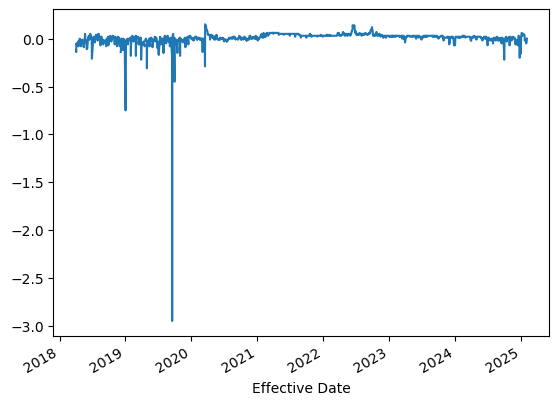

In [41]:
# SOFR starts in 2018 March. EFFR seems close enough for data before that.
dif = rates_df.groupby(['Rate Type', 'Effective Date']).first().loc['EFFR', 'Rate (%)'] - rates_df.groupby(['Rate Type', 'Effective Date']).first().loc['SOFR', 'Rate (%)']
dif.plot()

In [42]:
sofr_rates = rates_df.groupby(['Rate Type', 'Effective Date']).first().loc['SOFR', 'Rate (%)']
switch_day = sofr_rates.index[0]
effr_rates = rates_df.groupby(['Rate Type', 'Effective Date']).first().loc['EFFR'].loc[:switch_day - pd.Timedelta(days=1), 'Rate (%)']

In [43]:
risk_frees: pd.Series = pd.concat([effr_rates, sofr_rates])
dt = pd.date_range(risk_frees.index.min(), risk_frees.index.max(), freq='D')

rf_df = pd.DataFrame(index=dt, data=risk_frees)
rf_df['Rate (%)'] = rf_df['Rate (%)'].ffill()

merge stock price into option `agg_df`

In [44]:
firsts = agg_df.index.get_level_values('ts_event')
agg_df.loc[:, 'stock_close'] = resampled_stock_df.loc[firsts, 'close'].values
agg_df.loc[:, 'risk_free'] = (rf_df.loc[firsts, 'Rate (%)'] / 100).values
agg_df['time_to_expiry'] = agg_df['time_to_expiry'].apply(lambda x: x.days/365) # pd.Timedelta to number of years (float)

In [45]:
agg_df.head(20)

open  \
ts_event                  type strike expiry_date                           
2023-03-28 00:00:00+00:00 C    50.0   2023-03-31 00:00:00+00:00  107.3000   
                                      2023-04-21 00:00:00+00:00  106.3375   
                                      2024-01-19 00:00:00+00:00  108.4050   
                                      2025-01-17 00:00:00+00:00  109.3250   
                                      2025-12-19 00:00:00+00:00  110.9500   
                               55.0   2023-04-06 00:00:00+00:00  102.0500   
                               60.0   2023-03-31 00:00:00+00:00   97.3000   
                               65.0   2023-04-21 00:00:00+00:00   91.4500   
                               70.0   2023-04-06 00:00:00+00:00   86.6000   
                                      2023-04-21 00:00:00+00:00   87.4000   
                                      2024-01-19 00:00:00+00:00   89.5500   
                                      2025-06-20 00:00:00+00:00   93.0200   
                               80.0   2023-06-16 00:00:00+00:00   77.4700   
                                      2024-06-21 00:00:00+00:00   81.4700   
                               85.0   2023-06-16 00:00:00+00:00   73.8500   
                                      2023-07-21 00:00:00+00:00   74.3200   
                               90.0   2023-06-16 00:00:00+00:00   67.1000   
                                      2023-12-15 00:00:00+00:00   70.2500   
                                      2024-01-19 00:00:00+00:00   70.8100   
                                      2025-01-17 00:00:00+00:00   75.9000   

                                                                     high  \
ts_event                  type strike expiry_date                           
2023-03-28 00:00:00+00:00 C    50.0   2023-03-31 00:00:00+00:00  107.3000   
                                      2023-04-21 00:00:00+00:00  106.3375   
                                      2024-01-19 00:00:00+00:00  108.4050   
                                      2025-01-17 00:00:00+00:00  109.3250   
                                      2025-12-19 00:00:00+00:00  110.9500   
                               55.0   2023-04-06 00:00:00+00:00  102.0500   
                               60.0   2023-03-31 00:00:00+00:00   97.3000   
                               65.0   2023-04-21 00:00:00+00:00   91.4500   
                               70.0   2023-04-06 00:00:00+00:00   86.6000   
                                      2023-04-21 00:00:00+00:00   87.4000   
                                      2024-01-19 00:00:00+00:00   89.5500   
                                      2025-06-20 00:00:00+00:00   93.0200   
                               80.0   2023-06-16 00:00:00+00:00   77.4700   
                                      2024-06-21 00:00:00+00:00   81.4700   
                               85.0   2023-06-16 00:00:00+00:00   73.8500   
                                      2023-07-21 00:00:00+00:00   74.3200   
                               90.0   2023-06-16 00:00:00+00:00   67.1600   
                                      2023-12-15 00:00:00+00:00   70.2500   
                                      2024-01-19 00:00:00+00:00   70.8100   
                                      2025-01-17 00:00:00+00:00   75.9100   

                                                                     low  \
ts_event                  type strike expiry_date                          
2023-03-28 00:00:00+00:00 C    50.0   2023-03-31 00:00:00+00:00  107.300   
                                      2023-04-21 00:00:00+00:00  106.275   
                                      2024-01-19 00:00:00+00:00  108.405   
                                      2025-01-17 00:00:00+00:00  109.325   
                                      2025-12-19 00:00:00+00:00  110.950   
                               55.0   2023-04-06 00:00:00+00:00  102.050   
                               60.0   2023-03-31 00:00:00+00:00   97.30

In [46]:
agg_df = agg_df[['close', 'stock_close', 'time_to_expiry', 'risk_free']].rename(columns={'close': 'option_close'})
agg_df = agg_df.reset_index()

In [47]:
agg_df.head(5)

,ts_event,type,strike,expiry_date,option_close,stock_close,time_to_expiry,risk_free
0,2023-03-28 00:00:00+00:00,C,50.0,2023-03-31 00:00:00+00:00,107.300,157.63,0.008219,0.0484
1,2023-03-28 00:00:00+00:00,C,50.0,2023-04-21 00:00:00+00:00,106.275,157.63,0.065753,0.0484
2,2023-03-28 00:00:00+00:00,C,50.0,2024-01-19 00:00:00+00:00,108.405,157.63,0.813699,0.0484
3,2023-03-28 00:00:00+00:00,C,50.0,2025-01-17 00:00:00+00:00,109.325,157.63,1.810959,0.0484
4,2023-03-28 00:00:00+00:00,C,50.0,2025-12-19 00:00:00+00:00,110.950,157.63,2.731507,0.0484


In [48]:
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega

In [49]:
def implied_vol(S0, K, T, r, market_price, flag='C', tol=0.00001):
    max_iter = 200 #max number of iterations
    vol_old = 0.30 #initial guess

    for k in range(max_iter):
        bs_price = bs(flag.lower(), S0, K, T, r, vol_old)
        Cprime   = vega(flag.lower(), S0, K, T, r, vol_old) * 100
        if np.isnan(vol_old): break
        # print(k, vol_old, Cprime)
        C = bs_price - market_price
        vol_new = vol_old - C/Cprime
        bs_new = bs(flag.lower(), S0, K, T, r, vol_new)

        if (abs(vol_old - vol_new) < tol or abs(bs_new - market_price) < tol):
            break
        vol_old = vol_new

    implied_vol = vol_old
    return implied_vol

In [50]:
# test if the function works
S0, K, T, r = 30, 28, 0.2, 0.025
market_price = 3.97
implied_vol_est = implied_vol(S0, K, T, r, market_price, flag='C')
print(f"Implied Volatility = {implied_vol_est:.3%}")

Implied Volatility = 53.816%


In [ ]:
agg_df['implied_volatility'] = agg_df.apply(lambda row: implied_vol(
        S0=row['stock_close'],
        K=row['strike'],
        T=row['time_to_expiry'],
        r=row['risk_free'],  # Get risk-free rate by expiry date
        market_price=row['option_close'],
        flag=row['type']
), axis=1)

In [52]:
agg_df

,ts_event,type,strike,expiry_date,option_close,stock_close,time_to_expiry,risk_free,implied_volatility
0,2023-03-28 00:00:00+00:00,C,50.0,2023-03-31 00:00:00+00:00,107.300,157.63,0.008219,0.0484,NaN
1,2023-03-28 00:00:00+00:00,C,50.0,2023-04-21 00:00:00+00:00,106.275,157.63,0.065753,0.0484,NaN
2,2023-03-28 00:00:00+00:00,C,50.0,2024-01-19 00:00:00+00:00,108.405,157.63,0.813699,0.0484,NaN
3,2023-03-28 00:00:00+00:00,C,50.0,2025-01-17 00:00:00+00:00,109.325,157.63,1.810959,0.0484,NaN
4,2023-03-28 00:00:00+00:00,C,50.0,2025-12-19 00:00:00+00:00,110.950,157.63,2.731507,0.0484,NaN
...,...,...,...,...,...,...,...,...,...
462270,2024-12-31 00:00:00+00:00,P,320.0,2025-06-20 00:00:00+00:00,68.810,250.42,0.468493,0.0449,0.341947
462271,2024-12-31 00:00:00+00:00,P,330.0,2027-01-15 00:00:00+00:00,79.000,250.42,2.041096,0.0449,0.319253
462272,2024-12-31 00:00:00+00:00,P,350.0,2025-03-21 00:00:00+00:00,97.800,250.42,0.219178,0.0449,0.450333
462273,2024-12-31 00:00:00+00:00,P,370.0,2025-01-17 00:00:00+00:00,117.775,250.42,0.046575,0.0449,NaN


In [53]:
agg_df.to_csv(os.path.join(DATA_ROOT, "option_iv", f"{symbol}-iv-1d.csv"))

# Volatility Surface

In [6]:
import pandas as pd
import plotly.graph_objects as go

In [8]:
symbol = 'AAPL'

iv_df = pd.read_csv(os.path.join(DATA_ROOT, "option_iv", f"{symbol}-iv-1d.csv"), index_col=0)
iv_df['ts_event'] = pd.to_datetime(iv_df['ts_event'])
iv_df['expiry_date'] = pd.to_datetime(iv_df['expiry_date'])
iv_df.replace([np.inf, -np.inf], np.nan, inplace=True)

Choose one day, plot all option IVs (exclude nan or negative IVs; may have duplicate for the same strike/type)

In [10]:
# Create the DataFrame with the provided data
data = iv_df[iv_df['ts_event']=='2023-03-28']
data.loc[data['implied_volatility']<0, 'implied_volatility'] = 0.0

plot_df = pd.DataFrame(data)

# Convert `expiry_date` and `ts_event` to datetime
plot_df['expiry_date'] = pd.to_datetime(plot_df['expiry_date'])
plot_df['ts_event'] = pd.to_datetime(plot_df['ts_event'])
plot_df['S_ratio'] = (plot_df['strike'] / plot_df['stock_close'] - 1) * 100
plot_df['implied_volatility'] = plot_df['implied_volatility'] * 100

# # Calculate days to expiration
# plot_df['days_to_expiry'] = (plot_df['expiry_date'] - plot_df['ts_event']).dt.days / 365

fig = go.Figure(data=[go.Scatter3d(
    x=plot_df['S_ratio'],
    y=plot_df['time_to_expiry'],
    z=plot_df['implied_volatility'],
    mode='markers',
    marker=dict(
        size=5,
        color=plot_df['implied_volatility'],
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(
    title='Volatility Surface',
    scene=dict(
        xaxis_title='Strike',
        yaxis_title='Time to Expiry (Years)',
        zaxis_title='Implied Volatility (%)',
        aspectratio=dict(x=1, y=1, z=1.5)
    )
)

fig.update_layout(margin=dict(l=0,r=0,t=0,b=0), scene_camera=dict(eye=dict(x=2.0, y=2.0, z=0.75)))

fig.show()

c:\ProgramData\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\ProgramData\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



aggregate the same strike by sum

In [11]:
data

,ts_event,type,strike,expiry_date,option_close,stock_close,time_to_expiry,risk_free,implied_volatility
0,2023-03-28 00:00:00+00:00,C,50.0,2023-03-31 00:00:00+00:00,107.300000,157.63,0.008219,0.0484,NaN
1,2023-03-28 00:00:00+00:00,C,50.0,2023-04-21 00:00:00+00:00,106.275000,157.63,0.065753,0.0484,NaN
2,2023-03-28 00:00:00+00:00,C,50.0,2024-01-19 00:00:00+00:00,108.405000,157.63,0.813699,0.0484,NaN
3,2023-03-28 00:00:00+00:00,C,50.0,2025-01-17 00:00:00+00:00,109.325000,157.63,1.810959,0.0484,NaN
4,2023-03-28 00:00:00+00:00,C,50.0,2025-12-19 00:00:00+00:00,110.950000,157.63,2.731507,0.0484,NaN
...,...,...,...,...,...,...,...,...,...
1070,2023-03-28 00:00:00+00:00,P,255.0,2023-10-20 00:00:00+00:00,98.695000,157.63,0.564384,0.0484,0.627517
1071,2023-03-28 00:00:00+00:00,P,255.0,2023-12-15 00:00:00+00:00,98.600000,157.63,0.717808,0.0484,0.592653
1072,2023-03-28 00:00:00+00:00,P,255.0,2024-01-19 00:00:00+00:00,98.335000,157.63,0.813699,0.0484,0.572007
1073,2023-03-28 00:00:00+00:00,P,265.0,2024-01-19 00:00:00+00:00,108.350000,157.63,0.813699,0.0484,0.606735


In [12]:
data = iv_df[iv_df['ts_event']=='2023-03-28']
data.loc[data['implied_volatility']<0, 'implied_volatility'] = 0.0

cols = ['type', 'strike', 'expiry_date', 'option_close',
       'stock_close', 'time_to_expiry', 'risk_free', 'implied_volatility']

data = (data[cols].groupby(['strike', 'type', 'expiry_date']).sum() / data[cols].groupby(['strike', 'type', 'expiry_date']).count()).reset_index()

In [13]:
data

,strike,type,expiry_date,option_close,stock_close,time_to_expiry,risk_free,implied_volatility
0,50.0,C,2023-03-31 00:00:00+00:00,107.300000,157.63,0.008219,0.0484,NaN
1,50.0,C,2023-04-21 00:00:00+00:00,106.275000,157.63,0.065753,0.0484,NaN
2,50.0,C,2024-01-19 00:00:00+00:00,108.405000,157.63,0.813699,0.0484,NaN
3,50.0,C,2025-01-17 00:00:00+00:00,109.325000,157.63,1.810959,0.0484,NaN
4,50.0,C,2025-12-19 00:00:00+00:00,110.950000,157.63,2.731507,0.0484,NaN
...,...,...,...,...,...,...,...,...
1070,310.0,C,2024-06-21 00:00:00+00:00,0.390000,157.63,1.235616,0.0484,0.262754
1071,310.0,C,2025-01-17 00:00:00+00:00,0.742500,157.63,1.810959,0.0484,0.231574
1072,310.0,C,2025-12-19 00:00:00+00:00,2.755000,157.63,2.731507,0.0484,0.232042
1073,320.0,C,2024-01-19 00:00:00+00:00,0.040000,157.63,0.813699,0.0484,0.264918


In [14]:
plot_df = pd.DataFrame(data)

# Convert `expiry_date` and `ts_event` to datetime
plot_df['expiry_date'] = pd.to_datetime(plot_df['expiry_date'])
# plot_df['ts_event'] = pd.to_datetime(plot_df['ts_event'])
plot_df['S_ratio'] = (plot_df['strike'] / plot_df['stock_close'] - 1) * 100
plot_df['implied_volatility'] = plot_df['implied_volatility'] * 100

# # Calculate days to expiration
# plot_df['days_to_expiry'] = (plot_df['expiry_date'] - plot_df['ts_event']).dt.days / 365

fig = go.Figure(data=[go.Scatter3d(
    x=plot_df['S_ratio'],
    y=plot_df['time_to_expiry'],
    z=plot_df['implied_volatility'],
    mode='markers',
    marker=dict(
        size=5,
        color=plot_df['implied_volatility'],
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(
    title='Volatility Surface',
    scene=dict(
        xaxis_title='Strike',
        yaxis_title='Time to Expiry (Years)',
        zaxis_title='Implied Volatility (%)',
        aspectratio=dict(x=1, y=1, z=1.5)
    )
)

fig.update_layout(margin=dict(l=0,r=0,t=0,b=0), scene_camera=dict(eye=dict(x=2.0, y=2.0, z=0.75)))

fig.show()

c:\ProgramData\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\ProgramData\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



$$ \text{Look at } \frac{ IV_{M7} }{ IV_{SPX }} $$
where $ IV_{M7} = \sqrt{ \sum_{i=1}^{7} w_i^2 IV_i^2 + Corr }$ ; Corr is the CBOE correlation index.

try to see if this ratio changes over time

In [15]:
weights_df = pd.read_csv(os.path.join(DATA_ROOT, 'mag7-wgt-approx.csv'), index_col=0)
weights_df.index = pd.to_datetime(weights_df.index)

In [16]:
weights_df

,AAPL,MSFT,AMZN,GOOG,NVDA,TSLA,OTHERS
ts_event,,,,,,,
2018-05-01 00:00:00+00:00,0.031158,0.031985,0.036300,0.012004,0.006789,0.002771,0.878993
2018-05-02 00:00:00+00:00,0.031369,0.032201,0.036545,0.012085,0.006835,0.002790,0.878175
2018-05-03 00:00:00+00:00,0.031495,0.032465,0.036682,0.012104,0.007052,0.002641,0.877560
2018-05-04 00:00:00+00:00,0.032312,0.032422,0.036417,0.012235,0.007144,0.002696,0.876774
2018-05-05 00:00:00+00:00,0.032312,0.032422,0.036417,0.012235,0.007144,0.002696,0.876774
...,...,...,...,...,...,...,...
2024-12-27 00:00:00+00:00,0.076233,0.063160,0.041317,0.018222,0.066316,0.023787,0.710965
2024-12-28 00:00:00+00:00,0.076233,0.063160,0.041317,0.018222,0.066316,0.023787,0.710965
2024-12-29 00:00:00+00:00,0.076233,0.063160,0.041317,0.018222,0.066316,0.023787,0.710965


In [58]:
symbols = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']

iv_df = pd.read_csv(os.path.join(DATA_ROOT, 'option_iv', f'{symbols[0]}-iv-1d.csv'), index_col=0)
trading_days = iv_df[['ts_event']].groupby('ts_event').first().index
atm_df = pd.DataFrame(index=trading_days, columns=[f'{s}_iv' for s in symbols])

for symbol in symbols:
    iv_df = pd.read_csv(os.path.join(DATA_ROOT, 'option_iv', f'{symbol}-iv-1d.csv'), index_col=0)
    iv_df['ts_event'] = pd.to_datetime(iv_df['ts_event'], utc=True)
    iv_df['moneyness'] = iv_df['strike'] / iv_df['stock_close']

    for day in trading_days:
        filter_condition = (
            (iv_df['ts_event'] == day) &                                                    # on this day
            (iv_df['time_to_expiry'] >= 0.8/12) & (iv_df['time_to_expiry'] <= 1.2/12) &     # around one moth to expiry
            (iv_df['moneyness'] >= 0.95) & (iv_df['moneyness'] <= 1.05)                     # moneyness filtering
        )

        atm_df.loc[day, f'{symbol}_iv'] = iv_df.loc[filter_condition, ['implied_volatility']].mean(0).values[0]

In [68]:
atm_df[(atm_df[atm_df.columns] < 0).any(axis=1)]

,AAPL_iv,AMZN_iv,GOOG_iv,META_iv,MSFT_iv,NVDA_iv,TSLA_iv
ts_event,,,,,,,
2023-06-12 00:00:00+00:00,0.179648,0.290584,-0.073405,0.293166,0.207951,0.40828,0.564291
2023-06-22 00:00:00+00:00,0.184083,0.341597,-0.028461,0.348224,0.235946,0.409058,0.648307
2024-01-31 00:00:00+00:00,0.25639,0.39263,0.228503,0.409084,-82.676223,0.462021,0.424328
2024-02-07 00:00:00+00:00,0.189414,0.23672,0.221371,0.271346,-0.354388,0.535293,0.428608
2024-02-29 00:00:00+00:00,0.197003,0.245273,0.237244,0.280577,-0.004156,0.421375,0.428553
2024-05-23 00:00:00+00:00,0.190335,0.225994,-0.28408,0.266501,0.185973,0.402565,0.445311
2024-05-24 00:00:00+00:00,0.186739,0.214585,0.218231,0.259334,-0.242152,0.381334,0.432158


<Axes: xlabel='ts_event'>

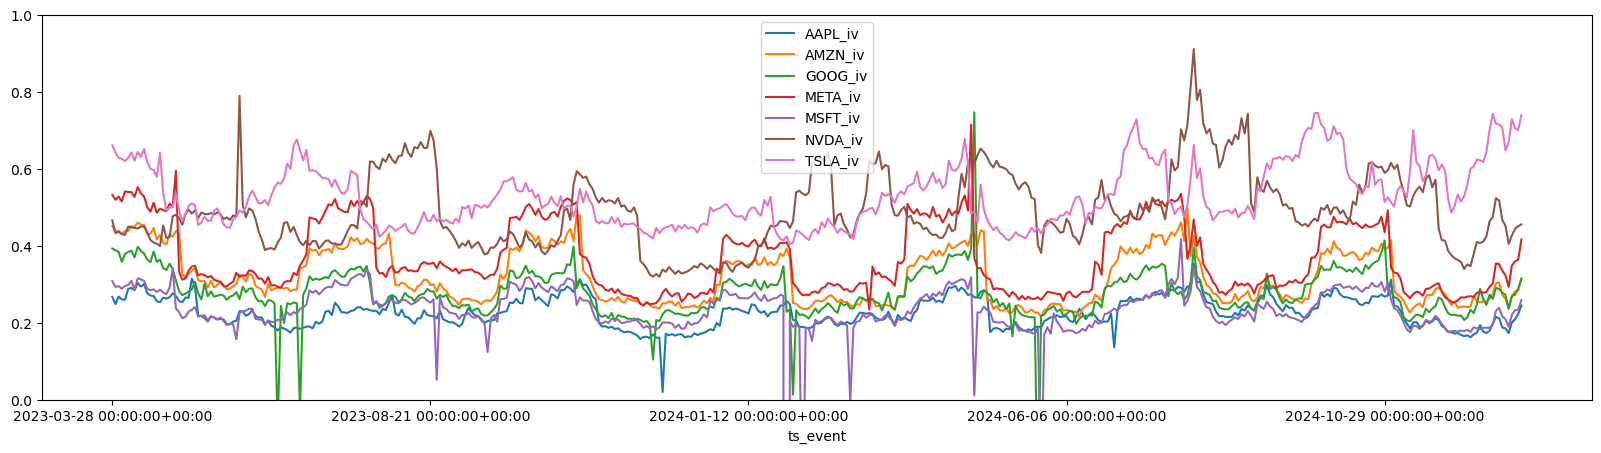

In [64]:
atm_df.plot(ylim=(0,1), figsize=(20,5))

In [53]:
symbols = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
symbol = symbols[1]

iv_df = pd.read_csv(os.path.join(DATA_ROOT, 'option_iv', f'{symbol}-iv-1d.csv'), index_col=0)
iv_df['ts_event'] = pd.to_datetime(iv_df['ts_event'], utc=True)
iv_df['moneyness'] = iv_df['strike'] / iv_df['stock_close']

In [46]:
trading_days = iv_df[['ts_event']].groupby('ts_event').first().index
atm_df = pd.DataFrame(index=trading_days, columns=[f'{s}_iv' for s in symbols])

In [55]:
for day in trading_days:
    filter_condition = (
        (iv_df['ts_event'] == day) &                                           # on this day
        (iv_df['time_to_expiry'] >= 0.8/12) & (iv_df['time_to_expiry'] <= 1.2/12) &     # around one moth to expiry
        (iv_df['moneyness'] >= 0.95) & (iv_df['moneyness'] <= 1.05)                     # moneyness filtering
    )

    atm_df.loc[day, f'{symbol}_iv'] = iv_df.loc[filter_condition, ['implied_volatility']].mean(0).values[0]

In [56]:
atm_df

,AAPL_iv,AMZN_iv,GOOG_iv,META_iv,MSFT_iv,NVDA_iv,TSLA_iv
ts_event,,,,,,,
2023-03-28 00:00:00+00:00,0.267095,0.451229,NaN,NaN,NaN,NaN,NaN
2023-03-29 00:00:00+00:00,0.248408,0.436223,NaN,NaN,NaN,NaN,NaN
2023-03-30 00:00:00+00:00,0.26785,0.439254,NaN,NaN,NaN,NaN,NaN
2023-03-31 00:00:00+00:00,0.260254,0.429147,NaN,NaN,NaN,NaN,NaN
2023-04-03 00:00:00+00:00,0.259626,0.438633,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-12-24 00:00:00+00:00,0.172908,0.237851,NaN,NaN,NaN,NaN,NaN
2024-12-26 00:00:00+00:00,0.200618,0.26983,NaN,NaN,NaN,NaN,NaN
2024-12-27 00:00:00+00:00,0.208781,0.281205,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='ts_event'>

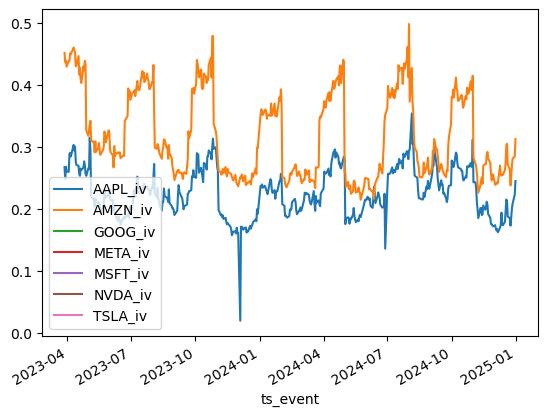

In [57]:
atm_df.plot()

In [34]:
filter_condition = (
    (iv_df['ts_event'] == '2024-12-31') &                                           # on this day
    (iv_df['time_to_expiry'] >= 0.8/12) & (iv_df['time_to_expiry'] <= 1.2/12) &     # around one moth to expiry
    (iv_df['moneyness'] >= 0.95) & (iv_df['moneyness'] <= 1.05)                     # moneyness filtering
)

iv_df.loc[filter_condition, ['ts_event', 'expiry_date', 'type', 'strike', 'stock_close', 'moneyness', 'implied_volatility']]

,ts_event,expiry_date,type,strike,stock_close,moneyness,implied_volatility
461491,2024-12-31 00:00:00+00:00,2025-01-31 00:00:00+00:00,C,240.0,250.42,0.958390,0.277072
461512,2024-12-31 00:00:00+00:00,2025-01-31 00:00:00+00:00,C,245.0,250.42,0.978356,0.265946
461531,2024-12-31 00:00:00+00:00,2025-01-31 00:00:00+00:00,C,250.0,250.42,0.998323,0.238945
461552,2024-12-31 00:00:00+00:00,2025-01-31 00:00:00+00:00,C,255.0,250.42,1.018289,0.237411
461571,2024-12-31 00:00:00+00:00,2025-01-31 00:00:00+00:00,C,260.0,250.42,1.038256,0.228406
462123,2024-12-31 00:00:00+00:00,2025-01-31 00:00:00+00:00,P,240.0,250.42,0.958390,0.256452
462144,2024-12-31 00:00:00+00:00,2025-01-31 00:00:00+00:00,P,245.0,250.42,0.978356,0.247600
462162,2024-12-31 00:00:00+00:00,2025-01-31 00:00:00+00:00,P,250.0,250.42,0.998323,0.239128
462183,2024-12-31 00:00:00+00:00,2025-01-31 00:00:00+00:00,P,255.0,250.42,1.018289,0.229681
462200,2024-12-31 00:00:00+00:00,2025-01-31 00:00:00+00:00,P,260.0,250.42,1.038256,0.227652


In [39]:
filter_condition = (
    (iv_df['ts_event'] == '2024-12-31') &                                           # on this day
    (iv_df['time_to_expiry'] >= 0.8/12) & (iv_df['time_to_expiry'] <= 1.2/12) &     # around one moth to expiry
    (iv_df['moneyness'] >= 0.95) & (iv_df['moneyness'] <= 1.05)                     # moneyness filtering
)

iv_df.loc[filter_condition, ['implied_volatility']].mean(0).values[0]

0.24482921995958223

## below for alex's idea simulation

In [2]:
import numpy as np

In [ ]:
# Set the number of weights and values
n = 500

# Generate n randomized positive weights that sum to one
weights = np.random.rand(n)
weights = weights / np.sum(weights)

# Generate n randomized values between -2 and 2
values = np.random.uniform(-2, 2, n)

residual_m = 0.15 ** 2
residual_e = 0.20 ** 2

variance = residual_m * (sum(weights * values))**2 + sum(weights**2) * residual_e
hhi = sum(weights**2)

In [49]:
import numpy as np
import plotly.express as px
import pandas as pd

# Set the number of weights and values
n = 5

# Set the number of simulations
num_simulations = 50000

# Define HHI batch intervals
start = 0.002
end   = 0.004
batch_width = 0.00005  # Constant width, can calculate once.
hhi_intervals = np.arange(start, end, batch_width)

# Initialize lists to store variance and HHI values
variances = []
hhis = []

# Run the simulation multiple times
for _ in range(num_simulations):
    # Generate n randomized positive weights that sum to one
    weights = np.random.rand(n)
    weights = weights / np.sum(weights)

    # Generate n randomized values between -2 and 2
    # values = np.random.uniform(-2, 2, n)
    values = np.random.normal(1, 0.1, n)

    # Calculate variance and HHI
    residual_m = 0.15 ** 2
    residual_e = 0.20 ** 2
    variance = residual_m * (sum(weights * values))**2 + sum(weights**2) * residual_e
    hhi = sum(weights**2)

    # Append the calculated values to the lists
    variances.append(variance)
    hhis.append(hhi)

# Create a DataFrame with the calculated values
df = pd.DataFrame({'HHI': hhis, 'Variance': variances})

# Create a scatter plot using Plotly
fig = px.scatter(df, x='HHI', y='Variance')

# Customize the plot
fig.update_layout(
    title='Variance vs. HHI',
    xaxis_title='HHI',
    yaxis_title='Variance'
)

# Show the plot
fig.show()

In [44]:
hhi_intervals

array([0.002  , 0.00205, 0.0021 , 0.00215, 0.0022 , 0.00225, 0.0023 ,
       0.00235, 0.0024 , 0.00245, 0.0025 , 0.00255, 0.0026 , 0.00265,
       0.0027 , 0.00275, 0.0028 , 0.00285, 0.0029 , 0.00295, 0.003  ,
       0.00305, 0.0031 , 0.00315, 0.0032 , 0.00325, 0.0033 , 0.00335,
       0.0034 , 0.00345, 0.0035 , 0.00355, 0.0036 , 0.00365, 0.0037 ,
       0.00375, 0.0038 , 0.00385, 0.0039 , 0.00395])

In [48]:
import numpy as np
import plotly.express as px
import pandas as pd

# Set the number of weights and values
n = 5

# Set the number of simulations
num_simulations = 50000

# Define HHI batch intervals
start = 0.02
end   = 0.04
batch_width = 0.0005  # Constant width, can calculate once.
hhi_intervals = np.arange(start, end, batch_width)

residual_m = 0.20 ** 2
residual_e = 0.20 ** 2

# Initialize a dictionary to store variances for each HHI batch
variance_batches = {interval: [] for interval in hhi_intervals[:-1]}

# Run the simulation multiple times
for _ in range(num_simulations):
    # Generate n randomized positive weights that sum to one
    weights = np.random.rand(n)
    weights = weights / np.sum(weights)

    # Generate n randomized values between -2 and 2
    # values = np.random.uniform(-2, 2, n)
    values = np.random.normal(1, 0.3, n)

    # Calculate variance and HHI
    
    variance = residual_m * (sum(weights * values)) ** 2 + sum(weights ** 2) * residual_e
    hhi = sum(weights ** 2)

    # Calculate the batch index using integer division
    batch_index = int((hhi-start) / batch_width)

    # Handle edge case where HHI is exactly 1.0
    if batch_index == len(hhi_intervals) - 1:
        batch_index -= 1

    # Add the variance to the corresponding batch
    variance_batches[hhi_intervals[batch_index]].append(variance)

# Calculate batch means and standard deviations
batch_means = []
batch_stds = []
batch_labels = []

for interval_start in hhi_intervals[:-1]:
    variances_in_batch = variance_batches[interval_start]
    if variances_in_batch:  # Check if the batch is not empty
        batch_means.append(np.mean(variances_in_batch))
        batch_stds.append(np.std(variances_in_batch))
    else:  # Handle empty batches (important for avoiding errors)
        batch_means.append(0)  # or np.nan, depending on how you want to handle it
        batch_stds.append(0)   # or np.nan
    batch_labels.append(f"({interval_start:.6f}, {interval_start + batch_width:.6f})")


# Create a DataFrame for plotting
df = pd.DataFrame({'HHI Batch': batch_labels, 'Mean Variance': batch_means, 'Std Dev': batch_stds})

#Ensure correct order for labels on x axis
df['HHI Batch Start'] = hhi_intervals[:-1]
df = df.sort_values('HHI Batch Start')


# Create a bar chart with error bars using Plotly
fig = px.bar(df, x='HHI Batch', y='Mean Variance', error_y='Std Dev',
             title='Mean Variance vs. HHI Batch (with Error Bars)',
             labels={'HHI Batch': 'HHI Interval', 'Mean Variance': 'Mean Variance'})

# Show the plot
fig.show()

IndexError: index 552 is out of bounds for axis 0 with size 40

In [27]:
df

,HHI Batch,Mean Variance,Std Dev,HHI Batch Start
0,"(0.002, 0.007)",0.0,0.0,0.00200
1,"(0.002, 0.007)",0.0,0.0,0.00201
2,"(0.002, 0.007)",0.0,0.0,0.00202
3,"(0.002, 0.007)",0.0,0.0,0.00203
4,"(0.002, 0.007)",0.0,0.0,0.00204
...,...,...,...,...
94,"(0.003, 0.008)",0.0,0.0,0.00294
95,"(0.003, 0.008)",0.0,0.0,0.00295
96,"(0.003, 0.008)",0.0,0.0,0.00296
97,"(0.003, 0.008)",0.0,0.0,0.00297
